#Фролов Владимир
**Stepik User ID: 541150734**

# Face Recognition Project

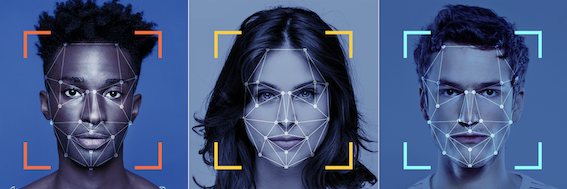

In this project you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

This basic notebook will give you 8/10 points, if completed fully. There are also additional features you might implement to get additional points. You may do additional tasks and receive additional points even if you didn't fully complete the basic notebook. This means you can choose which tasks to do. **Additional features that you might implement are listed in Telegram chat**.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

As you see on the site, images of celebA dataset look like this:


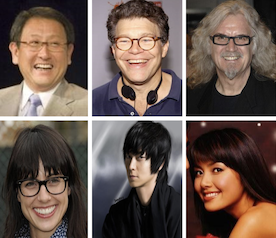

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

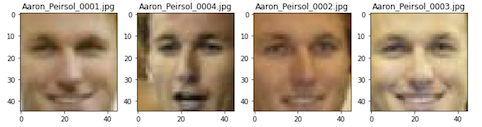

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

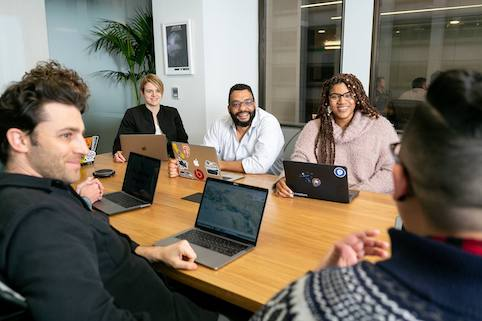

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

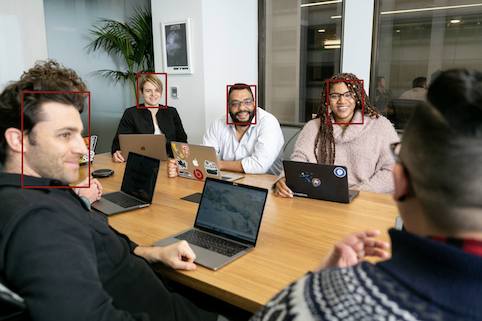

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

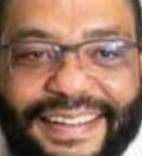

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is.

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people.

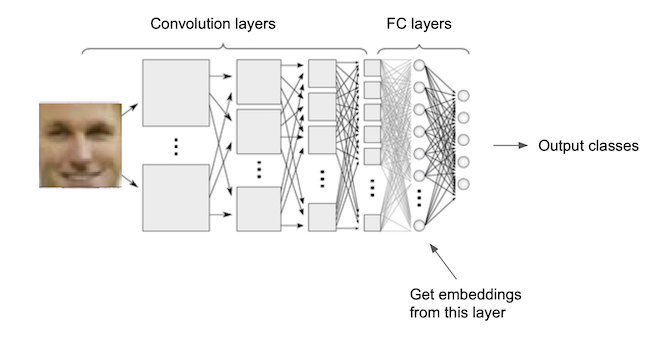

## Task 1 (2 points): build a neural network for faces classification as discribed above.

### Dataset

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw or using the code below:

In [ ]:
#! pip install wldhx.yadisk-direct
#! curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
#! unzip -qq celebA_train.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  162M  100  162M    0     0  7345k      0  0:00:22  0:00:22 --:--:-- 10.5M


In [ ]:
!pip install facenet_pytorch
!pip install pytorch_metric_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 2.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import math
import dlib
from pathlib import Path
from copy import deepcopy

import cv2
from cv2 import imread
from cv2 import imshow
from cv2 import waitKey
from cv2 import destroyAllWindows
from cv2 import CascadeClassifier
from cv2 import rectangle

import numpy as np
import pandas as pd
from PIL import Image
from time import time
from tqdm.notebook import tqdm, trange
from IPython.display import clear_output
from skimage import io, transform

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from pytorch_metric_learning import losses

import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import output

import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/pr/celebA -d celebA_original

Let's look at the data first:

In [ ]:
! ls celebA_original

celebA_original_landmarks.csv  celebA_train_split.txt  Photos


- Photos — folder within in-the-wild-images (not aligned)
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info
- celebA_original_landmarks.csv — file with landmark locations based on the coordinates of in-the-wild images and labels for face alignment

In [ ]:
for address, dirs, files in os.walk('/content/celebA_original'):
    print(address, dirs, len(files))

/content/celebA_original ['Photos'] 2
/content/celebA_original/Photos [] 12011


Let's visualize some images to understand what we're dealing with:

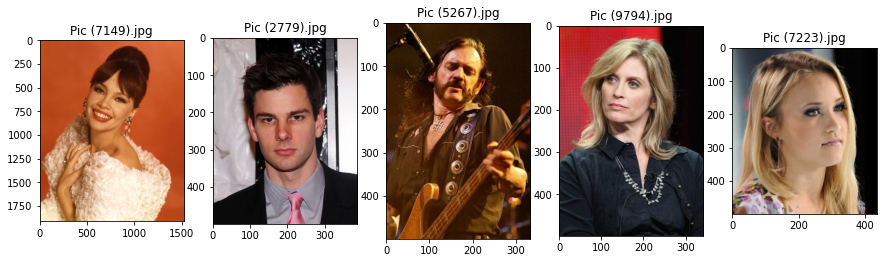

In [ ]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
        img = Image.open(os.path.join('celebA_original/Photos/', img))
        imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_original/Photos/')[:5]
show_imgs(images_names)

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:11]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

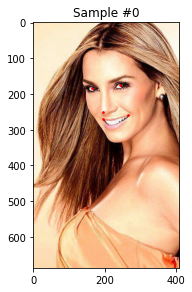

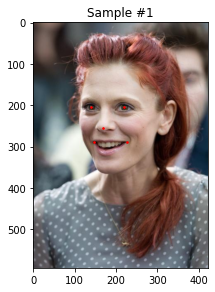

In [ ]:
face_dataset = FaceLandmarksDataset(csv_file='/content/celebA_original/celebA_original_landmarks.csv',
                                    root_dir='/content/celebA_original/Photos')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    ax = plt.subplot(1, 2, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    show_landmarks(**sample)

    if i == 1:
        plt.show()
        break

In [ ]:
df = pd.read_csv('/content/celebA_original/celebA_original_landmarks.csv')

lefteye_x, lefteye_y = df['lefteye_x'], df['lefteye_y']
righteye_x, righteye_y = df['righteye_x'], df['righteye_y']

lefteye_x, lefteye_y = np.array([lefteye_x]), np.array([lefteye_y])
righteye_x, righteye_y = np.array([righteye_x]), np.array([righteye_y])

lefteye_x, lefteye_y = lefteye_x.astype('float').reshape(-1, 1), lefteye_y.astype('float').reshape(-1, 1)
righteye_x, righteye_y = righteye_x.astype('float').reshape(-1, 1), righteye_y.astype('float').reshape(-1, 1)

sample = {'lefteye_x': lefteye_x, 'lefteye_y': lefteye_y, 'righteye_x': righteye_x,
          'righteye_y': righteye_y}

dl_labels_column = df.iloc[0:, 11]
dl_labels_column

0          0
1          1
2          2
3          3
4          4
        ... 
12006    495
12007    496
12008     41
12009    437
12010    467
Name: labels, Length: 12011, dtype: int64

In [ ]:
def face_detection(img):
    faces = face_detector.detectMultiScale(img, 1.1, 4)
    if (len(faces) <= 0):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img, img_gray
    else:
        X, Y, W, H = faces[0]
        img = img[int(Y):int(Y + H), int(X):int(X + W)]
        return img ,cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)


def face_alignment(img_path, landmarks):
    lefteye_x, lefteye_y = landmarks[0]
    righteye_x, righteye_y = landmarks[1]
    img_raw = cv2.imread(img_path)
    # finding rotation direction
    angle = math.atan((lefteye_y - righteye_y) / (lefteye_x - righteye_x)) * (180 / math.pi)
    origin_point = tuple(np.array(img_raw.shape[1::-1]) / 2)

    # Rotate using rotation matrix
    rot_mat = cv2.getRotationMatrix2D(origin_point, angle, 1.0)
    new_img = cv2.warpAffine(img_raw, rot_mat, img_raw.shape[1::-1], flags=cv2.INTER_LINEAR)

    return new_img


opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]

path = folders[0]
for folder in folders[1:]:
    path = path + "/" + folder

face_detector_path = path + "/data/haarcascade_frontalface_default.xml"

if os.path.isfile(face_detector_path) != True:
    raise ValueError('Confirm that opencv is installed on your environment! Expected path ', face_detector_path, ' violated')

face_detector = cv2.CascadeClassifier(face_detector_path)

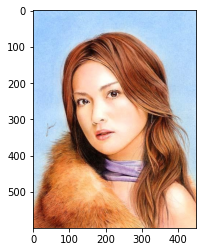

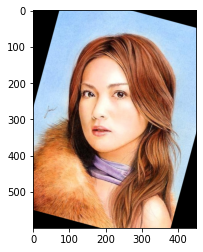

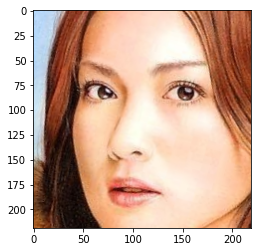

In [ ]:
test =['/content/celebA_original/Photos/Pic (88).jpg']
df = pd.read_csv('/content/celebA_original/celebA_original_landmarks.csv')
landmarks = df.iloc[87, 1:5]
landmarks = np.array([landmarks])
landmarks = landmarks.astype('float').reshape(-1, 2)

for i in test:
    plt.imshow(cv2.imread(i)[:, :, ::-1])
    plt.show()
    alignedFace = face_alignment(i, landmarks)
    plt.imshow(alignedFace[:, :, ::-1])
    plt.show()
    img, gray_img = face_detection(alignedFace)
    plt.imshow(img[:, :, ::-1])
    plt.show()

### Train Neural Network

Let's build a Datasets and network using this images:

In [ ]:
def detectface(img):
    opencv_img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2BGRA)
    faces = face_detector.detectMultiScale(img, 1.19, 6)
    if (len(faces) <= 0): # if the detector did not respond
        # im = Image.fromarray(img)
        # crop_img = transforms.functional.crop(im, top, left, height, width) --> too different image resolutions for this
        # Therefore, we will return the image that was input to the function
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        image = Image.fromarray(img_rgb)
        return image
    else:
        X, Y, W, H = faces[0]
        img = opencv_img[int(Y):int(Y + H), int(X):int(X + W)]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        image = Image.fromarray(img_rgb)
        return image
    return img

In [ ]:
img_name = os.path.basename('/content/celebA_original/Photos/Pic (88).jpg')
img_number = str(img_name.split('.')[0])
img_number = img_number.split('(')[1]
img_number = int(img_number.split(')')[0])
img_ind = img_number - 1
df.iloc[img_ind, 1:5]
isinstance(img_ind, int)

True

In [ ]:
def get_pths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('/content/celebA_original/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split(',') for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join('/content/celebA_original/Photos/', filename))

    return np.array(images_paths)


class celebADataset(Dataset):
    def __init__(self, dataset_type, transform, root_dir, csv_file):
        self.images = get_pths(dataset_type=dataset_type)

        self.root_dir = root_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_number = str(os.path.basename(img_name))
        img_number = str(img_number.split('.')[0])
        img_number = img_number.split('(')[1]
        img_number = int(img_number.split(')')[0])
        img_ind = img_number - 1
        label = self.df.iloc[img_ind, 11]
        landmarks = self.df.iloc[img_ind, 1:5]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)

        image = Image.open(img_name)
        aligned_face = face_alignment(img_name, landmarks)
        image_face = detectface(aligned_face)

        sample = {
            'image': self.transform(image_face),
            'label': label
        }

        return sample

In [ ]:
BM_WEIGHTS = '/content/gdrive/MyDrive/pr/best_model_weights'

In [ ]:
os.makedirs(BM_WEIGHTS, exist_ok=True)

In [ ]:
IMG_SIZE = (160, 160)
transform = transforms.Compose([
      # you may add anything, e.g. augmentation
      transforms.Resize(IMG_SIZE),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

augm = transforms.Compose([
      transforms.Resize(IMG_SIZE),
      transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
      transforms.RandomRotation(degrees=10, expand=False, center=None),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
train_data = celebADataset('train', augm, root_dir='/content/celebA_original/Photos',
                           csv_file='/content/celebA_original/celebA_original_landmarks.csv')
val_data = celebADataset('val', transform, root_dir='/content/celebA_original/Photos',
                         csv_file='/content/celebA_original/celebA_original_landmarks.csv')
test_data = celebADataset('test', transform, root_dir='/content/celebA_original/Photos',
                          csv_file='/content/celebA_original/celebA_original_landmarks.csv')

# choose your own batch_size
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

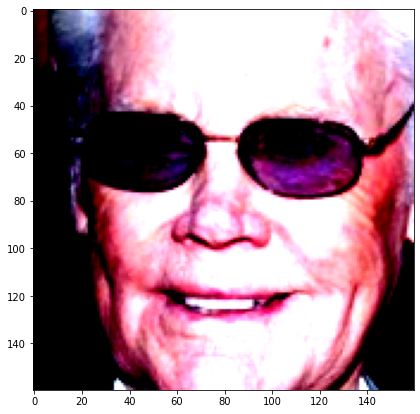

In [ ]:
for i in val_loader:
    plt.subplots(figsize=(15, 30))
    plt.subplot(1, 2, 1)
    plt.imshow(i['image'][20].permute(1, 2, 0))
    break

In [ ]:
len(train_data), len(val_data), len(test_data), len(train_loader), len(val_loader), len(test_loader)

(8544, 1878, 1589, 134, 30, 25)

**Workflow**: train a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training.

You may use whatever model you want, including pre-trained on ImageNet models from torchvision. Please note, that **it is not allowed to use pre-trained models on any other dataset except ImageNet**.

To get higher score, try to adjust hyperparameters, maybe try augmentations, etc.

Hints: Do not use too big model. Small ResNet-like network is enough to get the required score. Use at least 2 linear layers on the bottom. You'll need to drop the last layer after training and get image embeddings from the pre-last layer. It's not required to get the embedding from linear layer though: you may get it from last convolution layer, if you want.

**To get the whole mark for this section you need to achieve 70% accuracy on test set**.

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Sun Jan 29 16:53:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    26W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 26.09 MiB/s, done.
Resolving deltas: 100% (620/620), done.


In [ ]:
! ls models

inception_resnet_v1.py	mtcnn.py  utils


In [ ]:
from models import inception_resnet_v1
model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500).to(DEVICE)

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = False

In [ ]:
model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False).to(DEVICE)
model.last_bn = nn.BatchNorm1d(num_features=512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True).to(DEVICE)
model.logits = nn.Linear(in_features=512, out_features=500, bias=True).to(DEVICE)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs):
    since = time()

    train_losses = []
    val_losses = []
    train_full_acc = []
    val_full_acc = []
    best_acc = 0.0
    best_model_weights = deepcopy(model.state_dict())

    pbar = trange(epochs, desc='Epoch:')
    for epoch in pbar:
        print('---------- Epoch %d/%d ----------' % (epoch+1, epochs))
        # Train
        tr_loss = 0
        tr_acc = 0
        model.train()
        for batch in tqdm(train_loader):
            X_batch, Y_batch = batch['image'].to(DEVICE), torch.as_tensor(batch['label']).to(DEVICE)

            optimizer.zero_grad()
            # Forward
            Y_pred = model(X_batch).to(DEVICE)
            preds = torch.argmax(Y_pred, 1)
            loss = criterion(Y_pred, Y_batch)
            # Backward
            loss.backward()
            optimizer.step()

            tr_loss += loss.item() * X_batch.size(0)
            tr_acc += torch.sum(preds == Y_batch).cpu().detach().numpy()

        optimizer.step()
        train_loss = tr_loss / len(train_loader.sampler)
        train_losses.append(train_loss)
        train_acc = tr_acc / len(train_data)
        train_full_acc.append(train_acc)
        print('Train loss =', train_loss)
        print('Train accuracy = {:.2f}%'.format(train_acc.item() * 100))
        # Validation
        model.eval()
        v_loss = 0
        v_acc = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                X_val, Y_val = batch['image'].to(DEVICE), torch.as_tensor(batch['label']).to(DEVICE)
                Y_pred = model(X_val).to(DEVICE)

                loss = criterion(Y_pred, Y_val)
                preds = torch.argmax(Y_pred, 1)

                v_loss += loss.item() * X_val.size(0)
                v_acc += torch.sum(preds == Y_val).cpu().detach().numpy()

        val_loss = v_loss / len(val_loader.sampler)
        val_losses.append(val_loss)
        val_acc = v_acc / len(val_data)
        val_full_acc.append(val_acc)
        print('Val loss =', val_loss)
        print('Val accuracy = {:.2f}%'.format(val_acc.item() * 100))

        if val_acc >= best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(BM_WEIGHTS, 'Best_model_' + str(epoch+1) + '.pth'))
            best_model_weights = deepcopy(model.state_dict())
            print('Save best model!')

        scheduler.step()
        print(f'Time: {(time() - since)}')

    plt.subplots(figsize=(23, 9))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='train loss')
    plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    best_ep = np.argmin(val_losses) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='upper right')
    plt.title('Losses')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(train_full_acc) + 1), train_full_acc, label='train acc')
    plt.plot(np.arange(1, len(val_full_acc) + 1), val_full_acc, label='val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    best_ep = np.argmax(val_full_acc) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='upper right')
    plt.title('Scores')

    plt.show()

    return best_model_weights, train_losses, val_losses, train_full_acc, val_full_acc

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

---------- Epoch 1/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 4.431755024842109
Train accuracy = 39.04%


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 2.717410095456563
Val accuracy = 78.01%
Save best model!
Time: 1541.0031962394714
---------- Epoch 2/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 2.1381303612212563
Train accuracy = 79.24%


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 1.466332847698809
Val accuracy = 85.46%
Save best model!
Time: 3136.8582310676575
---------- Epoch 3/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 1.2474484423573098
Train accuracy = 86.94%


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 1.0616233106365347
Val accuracy = 87.01%
Save best model!
Time: 4665.454501867294
---------- Epoch 4/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.9256131122174781
Train accuracy = 88.76%


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.9627135194782505
Val accuracy = 87.43%
Save best model!
Time: 6186.188991546631
---------- Epoch 5/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.8171029090881348
Train accuracy = 89.33%


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.9101544960111347
Val accuracy = 87.75%
Save best model!
Time: 7695.957328557968


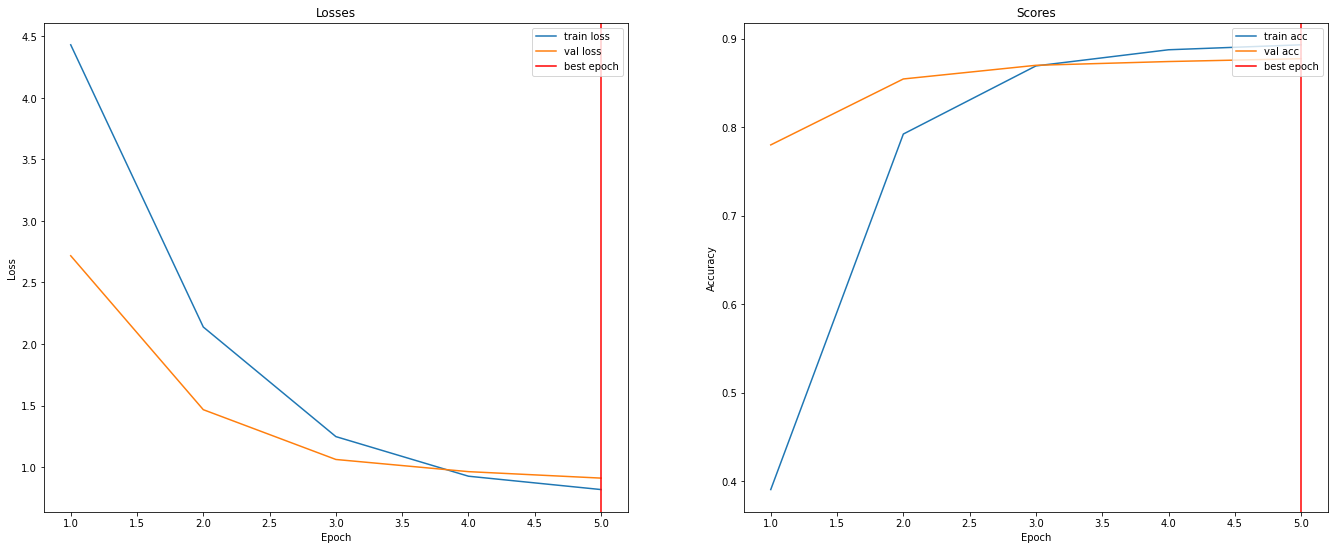

In [ ]:
torch.cuda.empty_cache()
best_model_weights, train_losses, val_losses, train_full_acc, val_full_acc = train(
    model, train_loader, val_loader, optimizer, scheduler, criterion, epochs=5
)

Code for model evaluating (you can modify it if you want):

In [ ]:
def evaluate(model, dataloader, loss_fn):

    losses = 0

    num_elements = 0

    model.eval()
    with torch.no_grad():
        num_correct = 0
        for batch in tqdm(dataloader):
            X_batch, y_batch = batch['image'].to(DEVICE), torch.as_tensor(batch['label']).to(DEVICE)
            num_elements += len(y_batch)
            logits = model(X_batch).to(DEVICE)
            y_pred = torch.argmax(logits, dim=1)

            output = loss_fn(logits, y_batch)
            losses += output.item() * X_batch.size(0)
            num_correct += torch.sum(y_pred.cpu() == y_batch.cpu())

    loss = losses / len(dataloader.sampler)
    print('Test loss =', loss)
    accuracy = num_correct / num_elements
    print('Test accuracy = {:.2f}%'.format(accuracy * 100))
    print('Correct answers: {} from {} '\
          .format(num_correct, len(test_data)))
    return accuracy.numpy(), loss

In [ ]:
best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)
best_model.load_state_dict(torch.load(os.path.join(BM_WEIGHTS, 'Best_model_5.pth')))
#best_model.load_state_dict(best_model_weights)
test_accuracy, test_loss = evaluate(best_model.to(DEVICE), test_loader, criterion)
test_accuracy, test_loss

  0%|          | 0/25 [00:00<?, ?it/s]

Test loss = 0.8271873330754855
Test accuracy = 88.67%
Correct answers: 1409 from 1589 


(array(0.8867212, dtype=float32), 0.8271873330754855)

**Cosine similarity calculation**: drop the last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [ ]:
best_model.classify = False

In [ ]:
!unzip -q /content/gdrive/My\ Drive/pr/celebA_train_500 -d celebA_train_500

In [ ]:
! ls celebA_train_500/celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder within in-the-wild-images (not aligned)
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [ ]:
def face_det(img):
    opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    faces = face_detector.detectMultiScale(opencv_image, 1.3, 5)

    if len(faces) > 0:
        face = faces[0]
        face_x, face_y, face_w, face_h = face
        opencv_image = opencv_image[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]

        color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(color_coverted)
        return pil_image

    return img

In [ ]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('/content/celebA_train_500/celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join('/content/celebA_train_500/celebA_train_500/celebA_imgs/', filename))

    return np.array(images_paths)


class celebADataset_for_CS(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('/content/celebA_train_500/celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        image_face = face_det(image)

        sample = {
            'image': self.transform(image_face),
            'label': label,
        }

        return sample

    def get_photos(self, person_number):
        photos = []
        for i, j in enumerate(self.labels):
            if j == person_number:
                photos.append(self.images[i])
        if len(photos) != 0:
            photos = torch.stack([self.transform(face_det(Image.open(x))) for x in photos])
        else:
            photos = torch.Tensor()
        return photos

In [ ]:
train_data_CS = celebADataset_for_CS('train', augm)
val_data_CS = celebADataset_for_CS('val', transform)
test_data_CS = celebADataset_for_CS('test', transform)

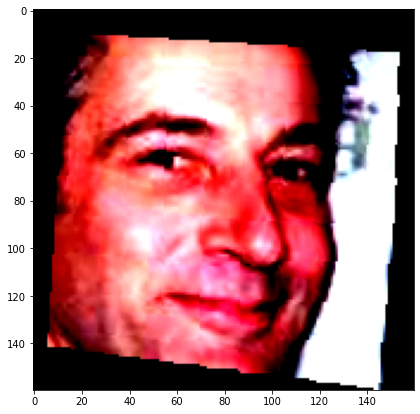

In [ ]:
batch_size = 64
train_loader_CS = torch.utils.data.DataLoader(train_data_CS, batch_size=batch_size, shuffle=True)
val_loader_CS = torch.utils.data.DataLoader(val_data_CS, batch_size=batch_size, shuffle=False)
test_loader_CS = torch.utils.data.DataLoader(test_data_CS, batch_size=batch_size, shuffle=False)
for i in train_loader_CS:
    plt.subplots(figsize=(15, 30))
    plt.subplot(1, 2, 1)
    plt.imshow(i['image'][0].permute(1, 2, 0))
    break

In [ ]:
best_model.eval()
with torch.no_grad():
    p1 = best_model(train_data_CS.get_photos(0).to(DEVICE))
    p2 = best_model(test_data_CS.get_photos(0).to(DEVICE))
    p3 = best_model(test_data_CS.get_photos(400).to(DEVICE))

In [ ]:
print(cosine_similarity(p1.cpu(), p2.cpu()).mean())
print(cosine_similarity(p1.cpu(), p3.cpu()).mean())

0.6435791
-0.07798079


In the first case (when comparing photographs of the same person), the difference is not so strong, because the mean value of the cosine is positive and greater than 0.5. Here, the differences are mainly related to different backgrounds (the background and shadows that falls into the bounding boxes) in the photo from the train and test sets.

In the second case, when photos of different people are compared, the difference is quite strong, since the average cosine value is negative.

Now let's calculate mean cosine similarities for 100 people from train and test to get heatmap of distribution

Analysis completed! We got 10000 person's mean cosine similarities.


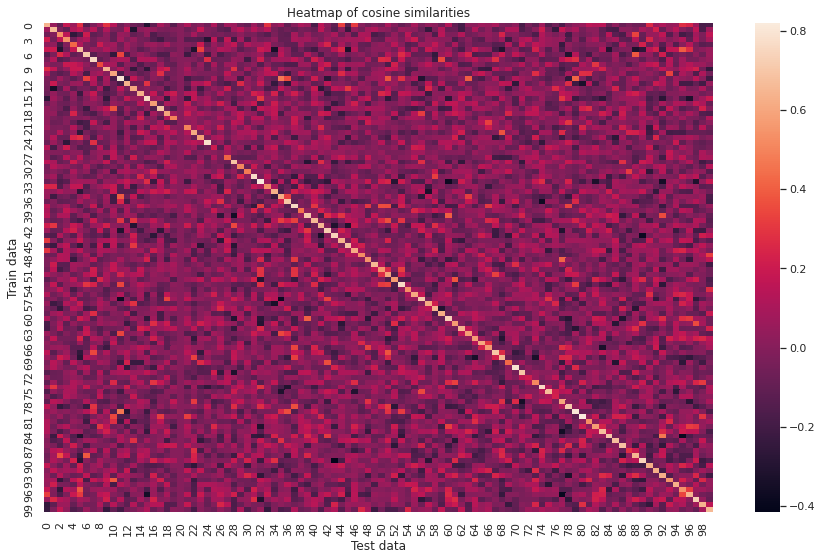

In [ ]:
N = 100
full_results = []
best_model.eval()
with torch.no_grad():
    for i in range(N):
        print('{}/{} person analysis...'.format(i + 1, N))
        results = []
        p1 = best_model(train_data_CS.get_photos(i).to(DEVICE))
        for j in range(N):
            if (len((test_data_CS.get_photos(j)) != 0)) and (len((train_data_CS.get_photos(i)) != 0)):
                p2 = best_model(test_data_CS.get_photos(j).to(DEVICE))
                results.append(cosine_similarity(p1.cpu(), p2.cpu()).mean())
            else:
                results.append(0.0)
        full_results.append(results)
        clear_output(wait=True)

corr_df = pd.DataFrame(np.array(full_results))
print('Analysis completed! We got {} person\'s mean cosine similarities.'.format(N ** 2))

sns.set(rc={'figure.figsize':(15,9)})
fig = sns.heatmap(np.array(full_results))
plt.title('Heatmap of cosine similarities')
plt.xlabel('Test data')
plt.ylabel('Train data')
plt.show()

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset.

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

Visualize (build histograms) the cosine similarities distributions for same and different people.

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between. For example, use 1000-5000 examples.

To get more than 5 000 positive distances, I analyse 50 people and calculate these values for each of them.

For negative pairs I combine person on label (i) and person on label (i + 5) - it's not unnecessary to choose person on label (i + 5) - I can take random person which (label != i), but it is easiest way to get more than 5k negative distances.

We got 8589 distances for same pairs!


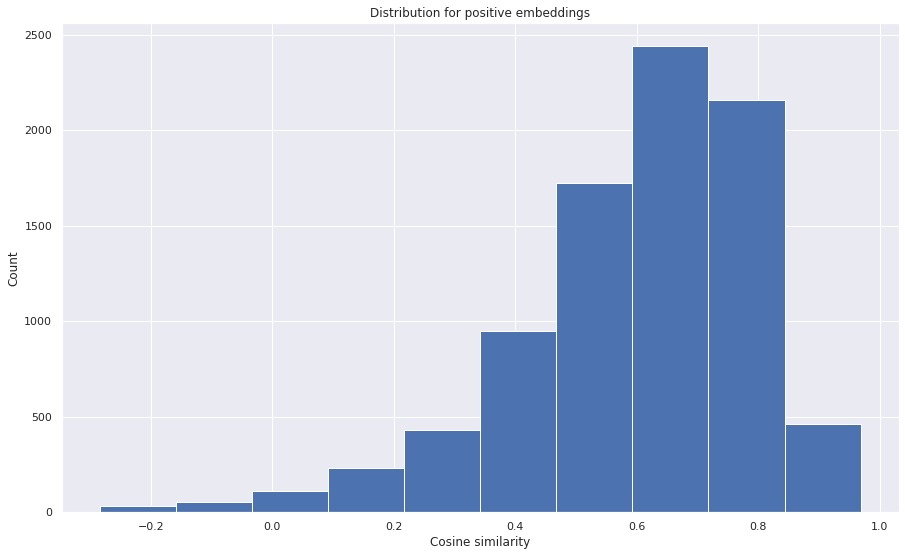

In [ ]:
best_model.eval()
positive_embeddings = torch.Tensor()
with torch.no_grad():
    for i in range(50):
        p = best_model(train_data_CS.get_photos(i).to(DEVICE))
        myembeddings = pd.DataFrame(cosine_similarity(p.cpu(), p.cpu()))
        myembeddings = myembeddings.mask(np.tril(np.ones(myembeddings.shape, dtype=np.bool_))).values.reshape(-1)
        useful_emb = torch.Tensor(myembeddings[~np.isnan(myembeddings)])
        positive_embeddings = torch.cat((positive_embeddings, useful_emb))

print('We got {} distances for same pairs!'.format(len(positive_embeddings)))

plt.hist(list(positive_embeddings))
plt.xlabel('Cosine similarity')
plt.ylabel('Count')
plt.title('Distribution for positive embeddings')
plt.show()

We got 8122 distances for different pairs!


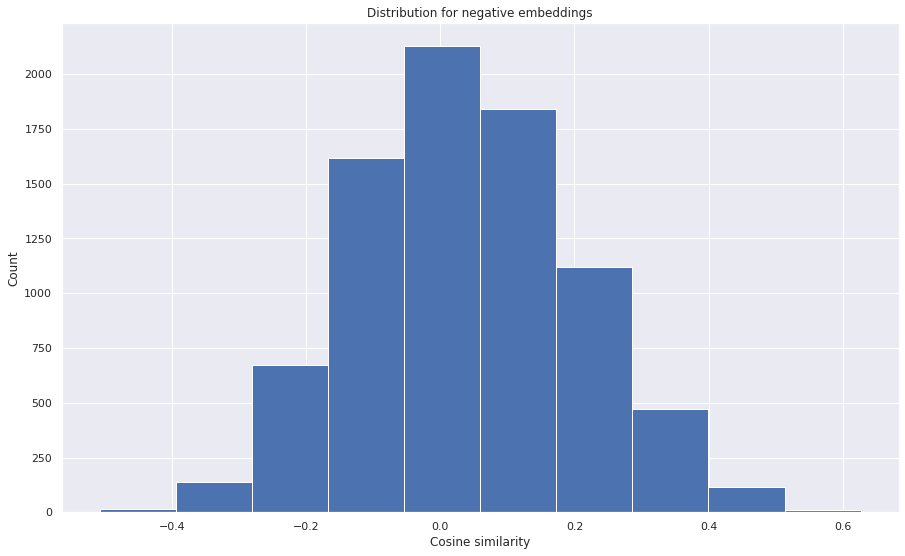

In [ ]:
best_model.eval()
negative_embeddings = torch.Tensor()
with torch.no_grad():
    for i in range(50):
        p1 = best_model(train_data_CS.get_photos(i).to(DEVICE))
        p2 = best_model(train_data_CS.get_photos(i+5).to(DEVICE))
        myembeddings = pd.DataFrame(cosine_similarity(p1.cpu(), p2.cpu()))
        myembeddings = myembeddings.mask(np.tril(np.ones(myembeddings.shape, dtype=np.bool_))).values.reshape(-1)
        useful_emb = torch.Tensor(myembeddings[~np.isnan(myembeddings)])
        negative_embeddings = torch.cat((negative_embeddings, useful_emb))

print('We got {} distances for different pairs!'.format(len(negative_embeddings)))

plt.hist(list(negative_embeddings))
plt.xlabel('Cosine similarity')
plt.ylabel('Count')
plt.title('Distribution for negative embeddings')
plt.show()

## Task 2 (2 points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos.
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset.
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary.

Datasets (query photos, query labels & distructors photos) you can download using the code below:

In [ ]:
#! curl -L $(yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ) -o celebA_ir.zip
#! unzip -qq celebA_ir.zip

In [ ]:
!unzip -q /content/gdrive/My\ Drive/pr/celebA_ir -d celebA_ir

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.


In [ ]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('/content/celebA_ir/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = ['/content/celebA_ir/celebA_ir/celebA_query/{}'.format(x[0]) for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = [
    '/content/celebA_ir/celebA_ir/celebA_distractors/{}'.format(x) for x in os.listdir('/content/celebA_ir/celebA_ir/celebA_distractors')
]

In [ ]:
len(distractors_img_names), len(query_img_names), len(query_dict)

(2001, 1222, 51)

In [ ]:
query_img_names[:5], distractors_img_names[:5]

(['/content/celebA_ir/celebA_ir/celebA_query/001265.jpg',
  '/content/celebA_ir/celebA_ir/celebA_query/001430.jpg',
  '/content/celebA_ir/celebA_ir/celebA_query/012834.jpg',
  '/content/celebA_ir/celebA_ir/celebA_query/041171.jpg',
  '/content/celebA_ir/celebA_ir/celebA_query/041823.jpg'],
 ['/content/celebA_ir/celebA_ir/celebA_distractors/020134.jpg',
  '/content/celebA_ir/celebA_ir/celebA_distractors/002354.jpg',
  '/content/celebA_ir/celebA_ir/celebA_distractors/119010.jpg',
  '/content/celebA_ir/celebA_ir/celebA_distractors/146846.jpg',
  '/content/celebA_ir/celebA_ir/celebA_distractors/093934.jpg'])

In [ ]:
class celebAirDataset(Dataset):
    def __init__(self, images_list, transform):
        self.images = images_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def get_tensors(self):
        images = torch.stack([self.transform(Image.open(img_name)) for img_name in self.images])

        return images

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name)

        image_face = face_det(image)

        return self.transform(image_face), idx

In [ ]:
def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  data = celebAirDataset(images_list, transform)
  model.to(DEVICE)
  loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=64, shuffle=False)

  model.eval()
  embeddings = []
  with torch.no_grad():
      for x in loader:
          pred = model(x.to(DEVICE))
          embeddings.append(pred.cpu())

  return torch.cat(embeddings)

In [ ]:
best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)
best_model.load_state_dict(torch.load(os.path.join(BM_WEIGHTS, 'Best_model_5.pth')))
best_model.classify = False

In [ ]:
query_embeddings = compute_embeddings(best_model, query_img_names)
distractors_embeddings = compute_embeddings(best_model, distractors_img_names)
query_embeddings.size(), distractors_embeddings.size()

(torch.Size([1222, 512]), torch.Size([2001, 512]))

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = '/content/celebA_ir/celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()

  for person_class in query_dict:
      images = [PATH.format(x) for x in query_dict[person_class]]
      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
              torch.Tensor(query_embeddings[query_img_names.index(image_path)])
          )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
          df = pd.DataFrame(result)
          df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)

          useful_result = df[~np.isnan(df)]
          useful_result = torch.Tensor(useful_result).view(-1)

          full_embeddings = torch.cat((full_embeddings, useful_result))

  results = [i.item() for i in full_embeddings]
  plt.hist(results)
  plt.xlabel('Cosine similarity')
  plt.ylabel('Count')
  plt.title('Distribution for cosine_query_pos')
  plt.show()
  print('Count of cosine similarities =', len(results))

  return results

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = '/content/celebA_ir/celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()
  class_counter = []

  m = 0
  for person_class in query_dict:
      m += 1
      print('Analyse {} persom of {}...'.format(m, len(query_dict)))
      images = [PATH.format(x) for x in query_dict[person_class]]
      class_counter.extend([person_class for i in range(len(images))])

      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
              torch.Tensor(query_embeddings[query_img_names.index(image_path)])
          )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          full_embeddings = torch.cat((full_embeddings, person_embeddings))

      clear_output(wait=True)

  all_data = pd.DataFrame(data={'class': class_counter, 'embeddings': list(full_embeddings)})
  results = cosine_similarity(full_embeddings, full_embeddings)
  results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

  n = 0
  for i in results:
      n += 1
      print('Analyse {} row of {}...'.format(n, len(results)))
      results.loc[i, i] = np.nan
      clear_output(wait=True)

  df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1)
  useful_result = df[~np.isnan(df)]
  plt.hist(useful_result)
  plt.xlabel('Cosine similarity')
  plt.ylabel('Count')
  plt.title('Distribution for cosine_query_neg')
  plt.show()
  print('Count of cosine similarities =', len(results))

  return useful_result

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  results = cosine_similarity(query_embeddings, distractors_embeddings)
  results = results.reshape(-1)
  plt.hist(results)
  plt.xlabel('Cosine similarity')
  plt.ylabel('Count')
  plt.title('Distribution for cosine_query_distractors')
  plt.show()
  print('Count of cosine similarities =', len(results))

  return results

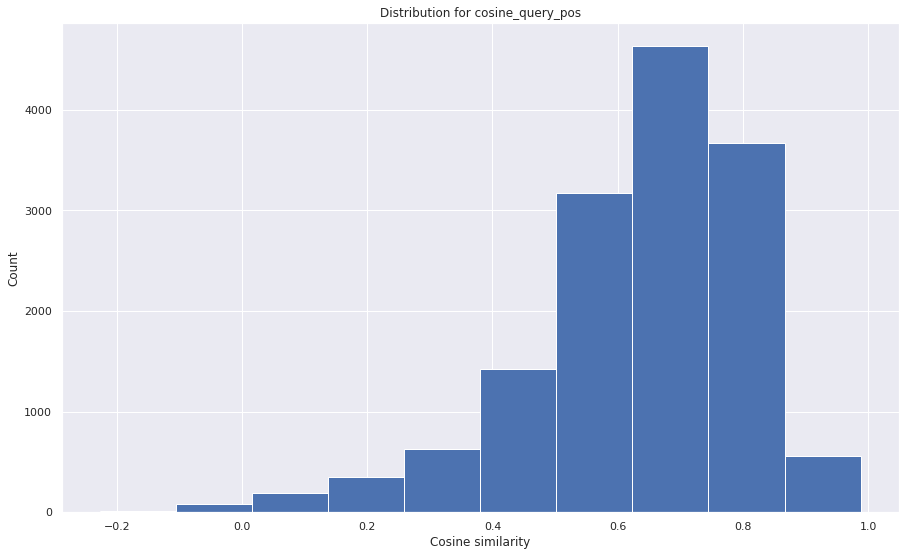

Count of cosine similarities = 14721


In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)

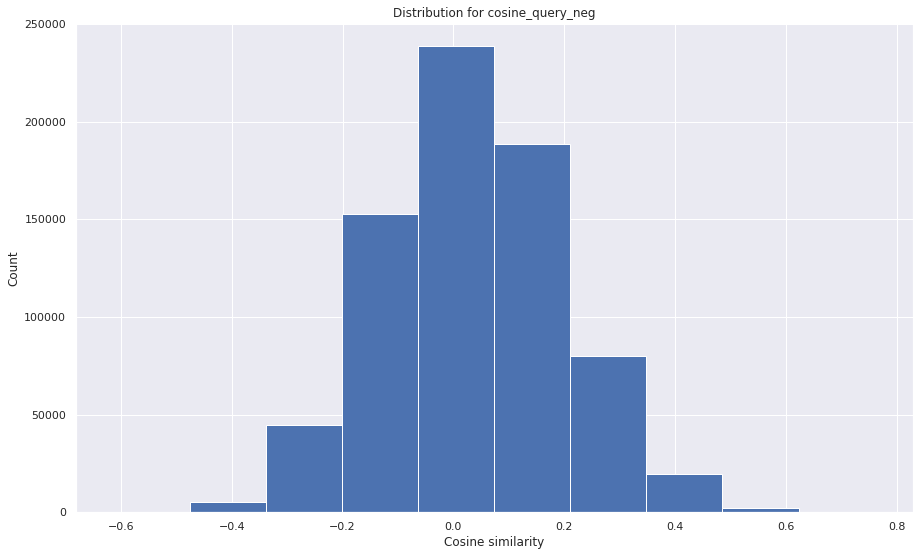

Count of cosine similarities = 1222


In [ ]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)

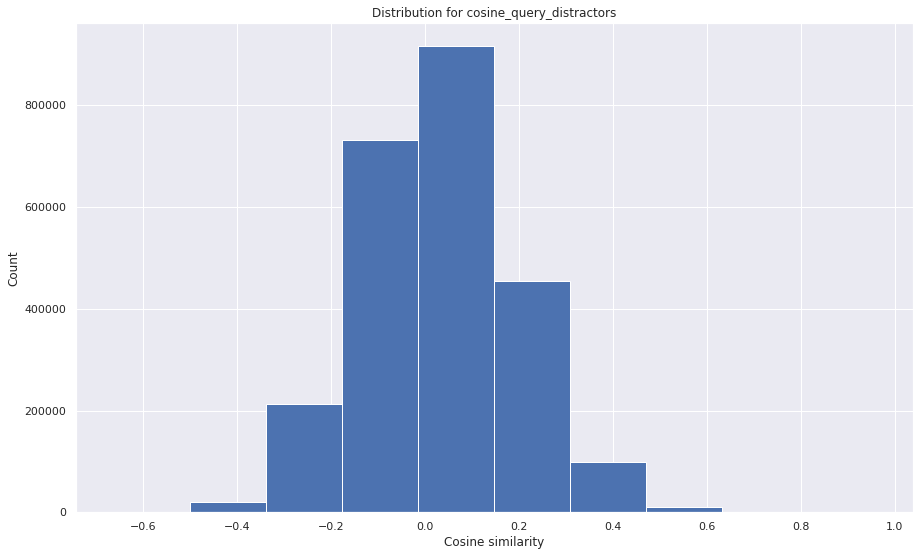

Count of cosine similarities = 2445222


In [ ]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

Check you code of functions which compute similarities:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

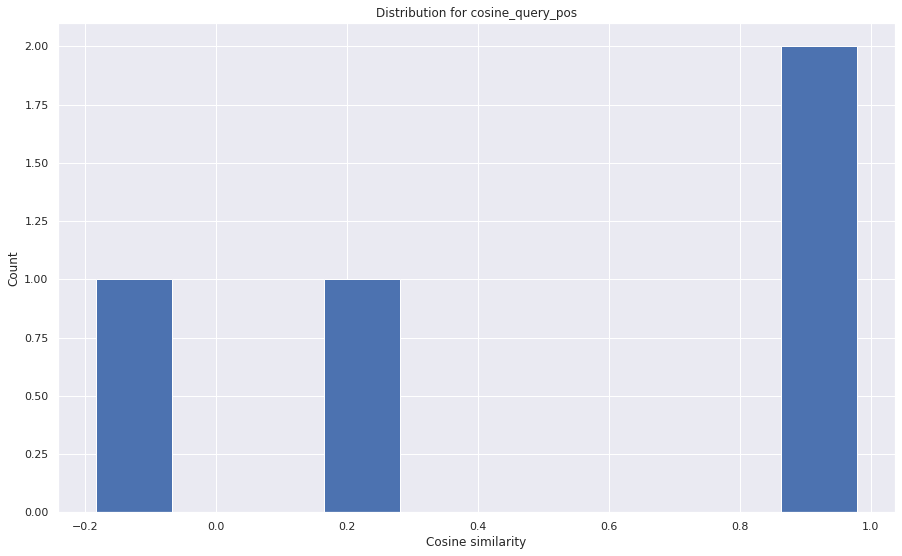

Count of cosine similarities = 4


In [ ]:
test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)

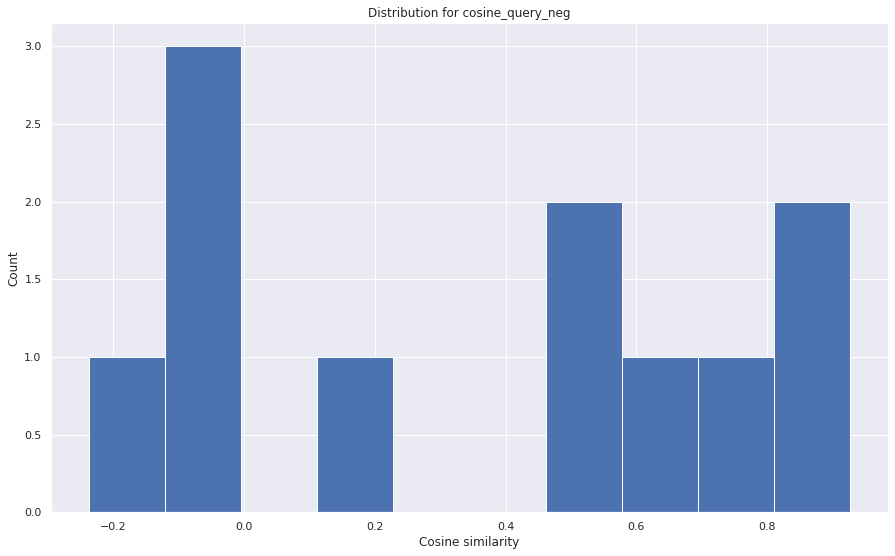

Count of cosine similarities = 6


In [ ]:
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)

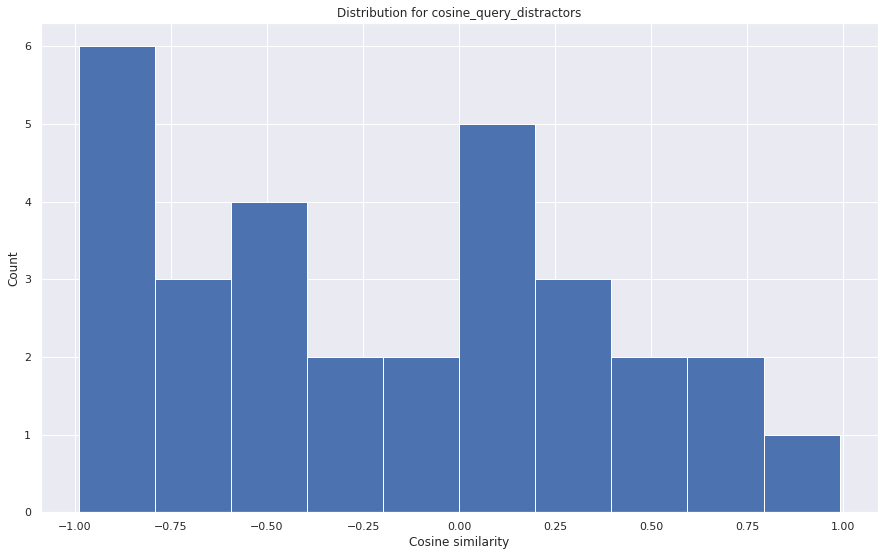

Count of cosine similarities = 30


In [ ]:
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  cosine_query_pos = torch.Tensor(cosine_query_pos)
  cosine_query_neg = torch.Tensor(cosine_query_neg)
  cosine_query_distractors = torch.Tensor(cosine_query_distractors)

  false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
  q = round(fpr * len(false_pairs))
  false_pairs = torch.sort(false_pairs, descending=True)[0]
  threshold = false_pairs[q]
  TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)

  return threshold.item(), TPR

Check yourself:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                      test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

print('FPR = 0.5:', (test_thr[0], test_tpr[0]), '\nFPR = 0.3:',
      (test_thr[1], test_tpr[1]), '\nFPR = 0.1:', (test_thr[2], test_tpr[2]))

FPR = 0.5: (-0.01198272779583931, 0.75) 
FPR = 0.3: (0.3371426463127136, 0.5) 
FPR = 0.1: (0.7013071179389954, 0.5)


In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [ ]:
thr = []
tpr = []

for fpr in [0.5, 0.2, 0.1, 0.05]:
    print('Analyse by fpr = {}'.format(fpr))
    x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                      cosine_query_distractors, fpr=fpr)
    thr.append(x)
    tpr.append(y)
    clear_output(wait=True)

print('FPR = 0.5:', (thr[0], tpr[0]), '\nFPR = 0.2:', (thr[1], tpr[1]),
      '\nFPR = 0.1:', (thr[2], tpr[2]), '\nFPR = 0.05:', (thr[3], tpr[3]))

FPR = 0.5: (0.028841402381658554, 0.992595611711161) 
FPR = 0.2: (0.16615010797977448, 0.9755451395964948) 
FPR = 0.1: (0.23995792865753174, 0.9622308267101419) 
FPR = 0.05: (0.3021262288093567, 0.9451803545954759)


## Task 3 (4 points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (2 points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other.

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo.

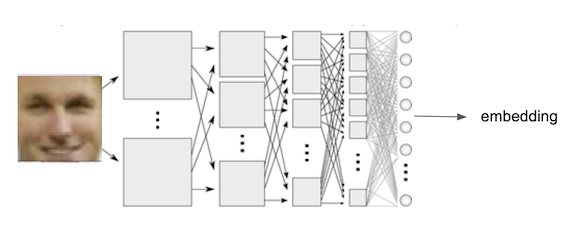

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.**
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embeddings from val and test sets calculate cosine similarities be

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [ ]:
class celebADatasetTL(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)
        self.dataset_type = dataset_type

        f = open('/content/celebA_train_500/celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        classes = np.arange(len(self.labels) - 1)
        pos, neg = np.random.choice(classes, size=2)

        img = self.images[pos]
        img_label = self.labels[pos]

        pos_label = self.labels[pos + 1]

        if pos_label != img_label:
            pos_img = self.images[pos - 1]
            pos_label = self.labels[pos - 1]
        else:
            pos_img = self.images[pos + 1]

        neg_img = self.images[neg]
        neg_label = self.labels[neg]

        image = Image.open(img)
        pos_image = Image.open(pos_img)
        neg_image = Image.open(neg_img)

        face = face_det(image)
        face_pos = face_det(pos_image)
        face_neg = face_det(neg_image)

        sample = {
            'image': self.transform(face),
            'image_label': img_label,
            'positive': self.transform(face_pos),
            'positive_label': pos_label,
            'negative': self.transform(face_neg),
            'negative_label': neg_label
        }

        return sample

In [ ]:
TL_BM_WEIGHTS = '/content/gdrive/MyDrive/pr/TL_best_model_weights'

In [ ]:
os.makedirs(TL_BM_WEIGHTS, exist_ok=True)

In [ ]:
train_TL = celebADatasetTL('train', augm)
val_TL = celebADatasetTL('val', transform)
test_TL = celebADatasetTL('test', transform)

batch_size = 64
train_TL_loader = torch.utils.data.DataLoader(train_TL, batch_size=batch_size, shuffle=True)
val_TL_loader = torch.utils.data.DataLoader(val_TL, batch_size=batch_size, shuffle=False)
test_TL_loader = torch.utils.data.DataLoader(test_TL, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_TL), len(val_TL), len(test_TL)

(8544, 1878, 1589)

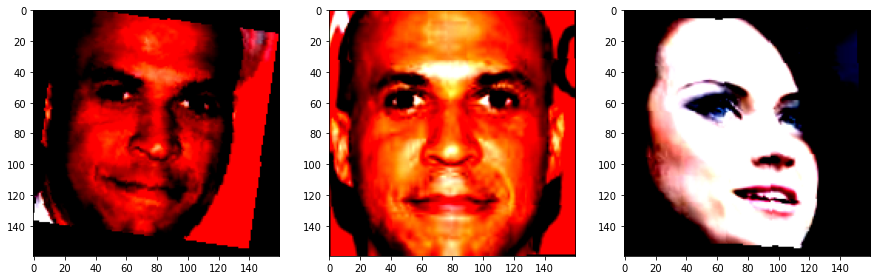

In [ ]:
for i in train_TL_loader:
    plt.subplots(figsize=(15, 30))
    plt.subplot(1, 3, 1)
    plt.imshow(i['image'][0].permute(1, 2, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(i['positive'][0].permute(1, 2, 0))
    plt.subplot(1, 3, 3)
    plt.imshow(i['negative'][0].permute(1, 2, 0))
    break

In [ ]:
def custom_distance_function(x, y):
    return 1.0 - F.cosine_similarity(x, y, dim=1)

In [ ]:
class Accuracy():
    def __init__(self, model, train_dataloader, batch_size=64):
        with torch.no_grad():
            self.model = model
            sum_embeddings = torch.zeros((500, 512)).to(DEVICE)
            cnt_embeddings = torch.zeros(500).to(DEVICE)
            for batch in train_dataloader:
                embeddings = model(batch['image'].to(DEVICE))
                for i in range(embeddings.shape[0]):
                    label = batch['image_label'][i]
                    sum_embeddings[label] += embeddings[i]
                    cnt_embeddings[label] += 1
            self.mean_value = torch.zeros((500, 512)).to(DEVICE)
            for j in range(500):
                self.mean_value[j] = sum_embeddings[j] / cnt_embeddings[j]

    def get(self, dataloader):
        sum = 0
        cnt = 0
        with torch.no_grad():
            for batch in dataloader:
                embeddings = self.model(batch['image'].to(DEVICE))
                for i in range(embeddings.shape[0]):
                    pred = F.cosine_similarity(torch.cat((embeddings[i][None][:],) * 500), self.mean_value, dim=1).argmax().item()
                    cnt += 1
                    sum += pred == batch['image_label'][i]
        return sum / cnt, sum, cnt

In [ ]:
def trainTL(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, margin):
    since = time()

    train_losses = []
    val_losses = []
    full_acc = []
    best_acc = 0.0
    TL_best_model_weights = deepcopy(model.state_dict())

    pbar = trange(epochs, desc='Epoch')

    for epoch in pbar:
        print('---------- Epoch %d/%d ----------' % (epoch+1, epochs))
        # Train
        tr_loss = 0
        model.train()
        for batch in tqdm(train_loader):
            # Forward
            optimizer.zero_grad()
            image, image_label = batch['image'].to(DEVICE), batch['image_label']
            positive, positive_label = batch['positive'].to(DEVICE), batch['positive_label']
            negative, negative_label = batch['negative'].to(DEVICE), batch['negative_label']

            img_emb = model(image).to(DEVICE)
            pos_emb = model(positive).to(DEVICE)
            neg_emb = model(negative).to(DEVICE)
            output = criterion(img_emb, pos_emb, neg_emb)
            # Backward
            output.backward()
            optimizer.step()

            tr_loss += output.item() * image.size(0)

        optimizer.step()
        train_loss = tr_loss / len(train_loader.sampler)
        train_losses.append(train_loss)
        print('Train loss =', train_loss)
        # Validation
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                image, image_label = batch['image'].to(DEVICE), batch['image_label']
                positive, positive_label = batch['positive'].to(DEVICE), batch['positive_label']
                negative, negative_label = batch['negative'].to(DEVICE), batch['negative_label']

                img_emb = model(image).to(DEVICE)
                pos_emb = model(positive).to(DEVICE)
                neg_emb = model(negative).to(DEVICE)

                output = criterion(img_emb, pos_emb, neg_emb)
                v_loss += output.item() * image.size(0)

        val_loss = v_loss / len(val_loader.sampler)
        val_losses.append(val_loss)
        # Accuracy
        accuracy, num_correct, num_elements = Accuracy(model, train_loader).get(val_loader)
        full_acc.append(accuracy)
        print('Val loss =', val_loss)
        print('Accuracy = {:.2f}%'.format(accuracy * 100))

        if accuracy >= best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), os.path.join(TL_BM_WEIGHTS, 'TL_Best_model_' + str(epoch+1) + ', margin = {}'.format(margin) + '.pth'))
            TL_best_model_weights = deepcopy(model.state_dict())
            print('Save best model!')

        scheduler.step()
        print(f'Time: {(time() - since)}')

    plt.subplots(figsize=(23, 9))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='train loss')
    plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    best_ep = np.argmin(val_losses) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='upper right')
    plt.title('TripletLosses, margin = {}'.format(margin))

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(full_acc) + 1), full_acc, label='acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    best_ep = np.argmax(full_acc) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='upper right')
    plt.title('Scores, margin = {}'.format(margin))

    plt.show()

    return TL_best_model_weights, train_losses, val_losses, full_acc

In [ ]:
def evaluateTL(model, dataloader, train_loader, criterion):
    model.eval()
    with torch.no_grad():
        losses = 0
        for batch in tqdm(dataloader):
            image, image_label = batch['image'], batch['image_label']
            positive, positive_label = batch['positive'], batch['positive_label']
            negative, negative_label = batch['negative'], batch['negative_label']

            img_emb = model(image.to(DEVICE))
            pos_emb = model(positive.to(DEVICE))
            neg_emb = model(negative.to(DEVICE))

            output = criterion(img_emb, pos_emb, neg_emb)
            losses += output.item() * image.size(0)

    loss = losses / len(dataloader.sampler)
    print('Test TripletLoss =', loss)

    accuracy, num_correct, num_elements = Accuracy(model, train_loader).get(dataloader)
    print('Test accuracy = {:.2f}%'.format(accuracy * 100))
    print('Correct answers: {} from {} '\
          .format(num_correct, num_elements))

    return loss, num_correct, accuracy

Testing MARGIN = 0.2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

---------- Epoch 1/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.01825561782533533


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.010149538745117771
Accuracy = 93.34%
Save best model!
Time: 801.0128555297852
---------- Epoch 2/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.01177554422019796


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.010233670534591833
Accuracy = 93.08%
Time: 1586.5170040130615
---------- Epoch 3/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.011525606427843987


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.010616370884421916
Accuracy = 0.00%
Time: 2370.6361186504364
---------- Epoch 4/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.010716326925415225


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.008974758090889746
Accuracy = 91.75%
Time: 3156.432096004486
---------- Epoch 5/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.010330774448114389


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.009311595032560908
Accuracy = 0.00%
Time: 3936.8378660678864


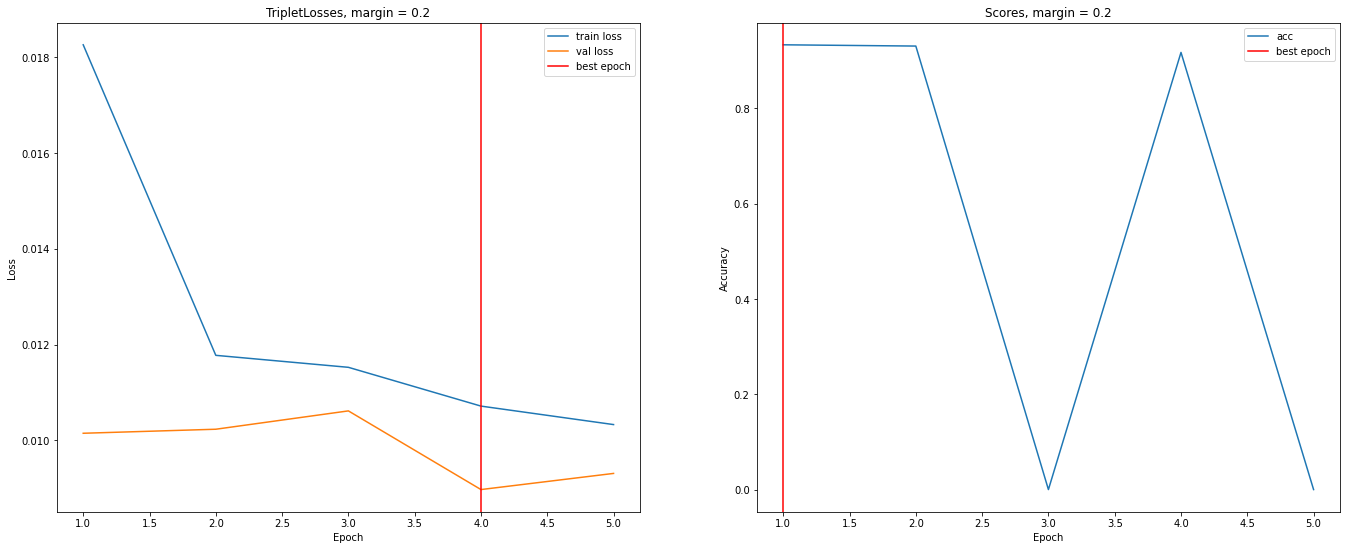

Start testing


  0%|          | 0/25 [00:00<?, ?it/s]

Test TripletLoss = 0.013459545289400129
Test accuracy = 91.50%
Correct answers: 1454 from 1589 


In [ ]:
torch.cuda.empty_cache()
margin = 0.2

criterion_TL = nn.TripletMarginWithDistanceLoss(
    distance_function = custom_distance_function, margin=margin
)
print('Testing MARGIN = {}'.format(margin))
# Loading pretrained model
TL_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
# Fine-tuning
for param in TL_model.parameters():
    param.requires_grad = False

TL_model.last_linear = nn.Linear(
    in_features=1792, out_features=512, bias=False
)

TL_model.last_bn = nn.BatchNorm1d(
    num_features=512, eps=0.001, momentum=0.1, affine=True,
    track_running_stats=True
)

TL_model.to(DEVICE)
# Training
optimizer = optim.Adam(TL_model.parameters(), lr=3e-4, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
TL_best_model_weights, train_TLosses, val_TLosses, acc = trainTL(
    TL_model, train_TL_loader, val_TL_loader, optimizer, scheduler, criterion_TL,
    epochs=5, margin=margin
)
# Loading best model
TL_best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
TL_best_model.load_state_dict(TL_best_model_weights)
# Testing best model
print('Start testing')
test_TLoss, correct, test_accuracy = evaluateTL(
    TL_best_model.to(DEVICE), test_TL_loader, train_TL_loader, criterion_TL
)

Testing MARGIN = 0.3


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

---------- Epoch 1/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.0390998666987437


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.01710889378564553
Accuracy = 92.12%
Save best model!
Time: 764.6079185009003
---------- Epoch 2/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.024711211780539612


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.01647318348970911
Accuracy = 91.43%
Time: 1552.535944223404
---------- Epoch 3/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.021715420113409056


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.014774056042408664
Accuracy = 0.00%
Time: 2313.6236307621
---------- Epoch 4/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.019609158502870733


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.01397537613829104
Accuracy = 91.80%
Time: 3064.3290684223175
---------- Epoch 5/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.019767344039812517


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.016627476492121068
Accuracy = 91.53%
Time: 3811.9295349121094


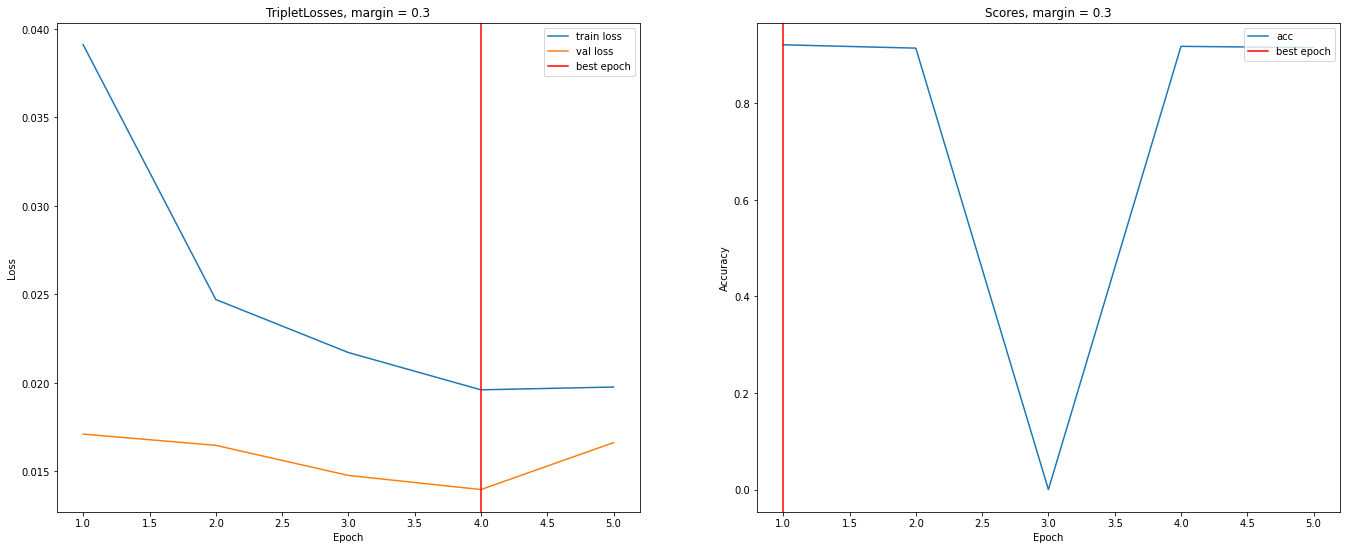

Start testing


  0%|          | 0/25 [00:00<?, ?it/s]

Test TripletLoss = 0.02601540482516856
Test accuracy = 91.38%
Correct answers: 1452 from 1589 


In [ ]:
torch.cuda.empty_cache()
margin = 0.3
criterion_TL = nn.TripletMarginWithDistanceLoss(
    distance_function = custom_distance_function, margin=margin
)
print('Testing MARGIN = {}'.format(margin))
# Loading pretrained model
TL_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
# Fine-tuning
for param in TL_model.parameters():
    param.requires_grad = False

TL_model.last_linear = nn.Linear(
    in_features=1792, out_features=512, bias=False
)

TL_model.last_bn = nn.BatchNorm1d(
    num_features=512, eps=0.001, momentum=0.1, affine=True,
    track_running_stats=True
)

TL_model.to(DEVICE)
# Training
optimizer = optim.Adam(TL_model.parameters(), lr=3e-4, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
TL_best_model_weights, train_TLosses, val_TLosses, acc = trainTL(
    TL_model, train_TL_loader, val_TL_loader, optimizer, scheduler, criterion_TL,
    epochs=5, margin=margin
)

# Loading best model
TL_best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
TL_best_model.load_state_dict(TL_best_model_weights)
# Testing best model
print('Start testing')
test_TLoss, correct, test_accuracy = evaluateTL(
    TL_best_model.to(DEVICE), test_TL_loader, train_TL_loader, criterion_TL
)

Testing MARGIN = 0.35


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

---------- Epoch 1/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.05508376256133733


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.02284907521451878
Accuracy = 0.00%
Save best model!
Time: 776.7912256717682
---------- Epoch 2/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.032653897554240426


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.02212491505942977
Accuracy = 90.47%
Save best model!
Time: 1540.5257008075714
---------- Epoch 3/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.028603370011913196


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.02188502284137808
Accuracy = 90.63%
Save best model!
Time: 2305.4389934539795
---------- Epoch 4/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.02759432563146625


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.027969843482834718
Accuracy = 92.60%
Save best model!
Time: 3073.4094688892365
---------- Epoch 5/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.02565352740428979


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.020632946505226173
Accuracy = 91.16%
Time: 3839.115189552307


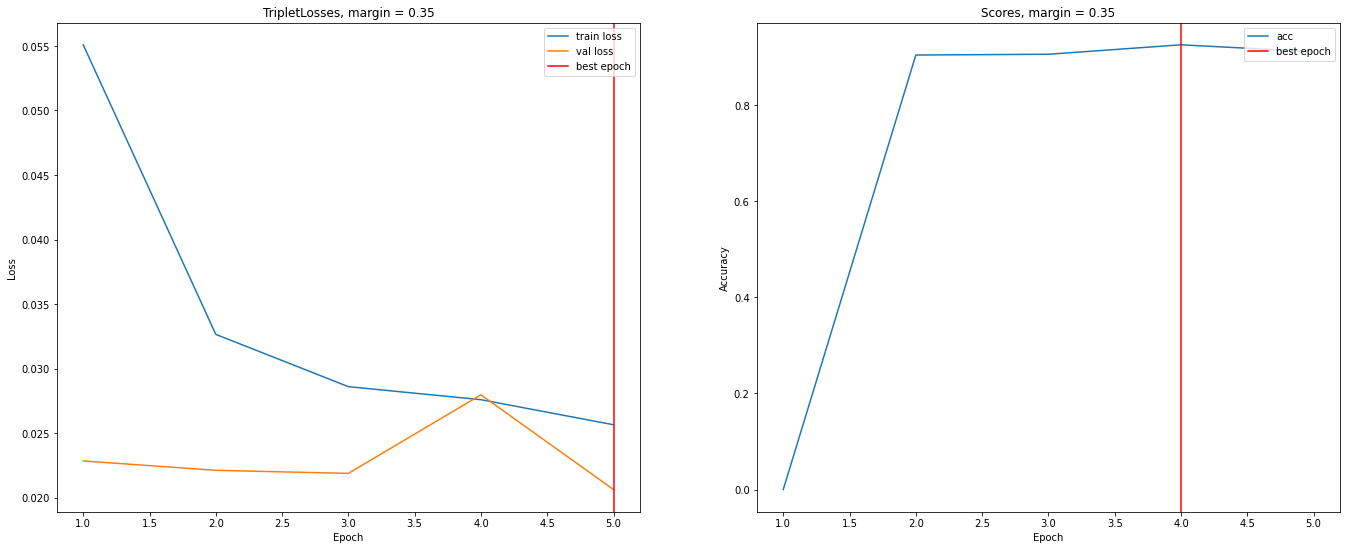

Start testing


  0%|          | 0/25 [00:00<?, ?it/s]

Test TripletLoss = 0.030714487440091698
Test accuracy = 91.76%
Correct answers: 1458 from 1589 
Testing MARGIN = 0.4


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

---------- Epoch 1/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.07206613082117802


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.028994440008847478
Accuracy = 90.10%
Save best model!
Time: 769.3656756877899
---------- Epoch 2/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.04383065319909585


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.024324985675283642
Accuracy = 90.63%
Save best model!
Time: 1535.8566162586212
---------- Epoch 3/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.037788309826609794


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.03052651609618443
Accuracy = 91.80%
Save best model!
Time: 2299.355736732483
---------- Epoch 4/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.035423422915937745


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.027975533486872563
Accuracy = 91.75%
Time: 3065.389241218567
---------- Epoch 5/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.03255800209409289


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.022966457346376902
Accuracy = 0.00%
Time: 3837.0602898597717


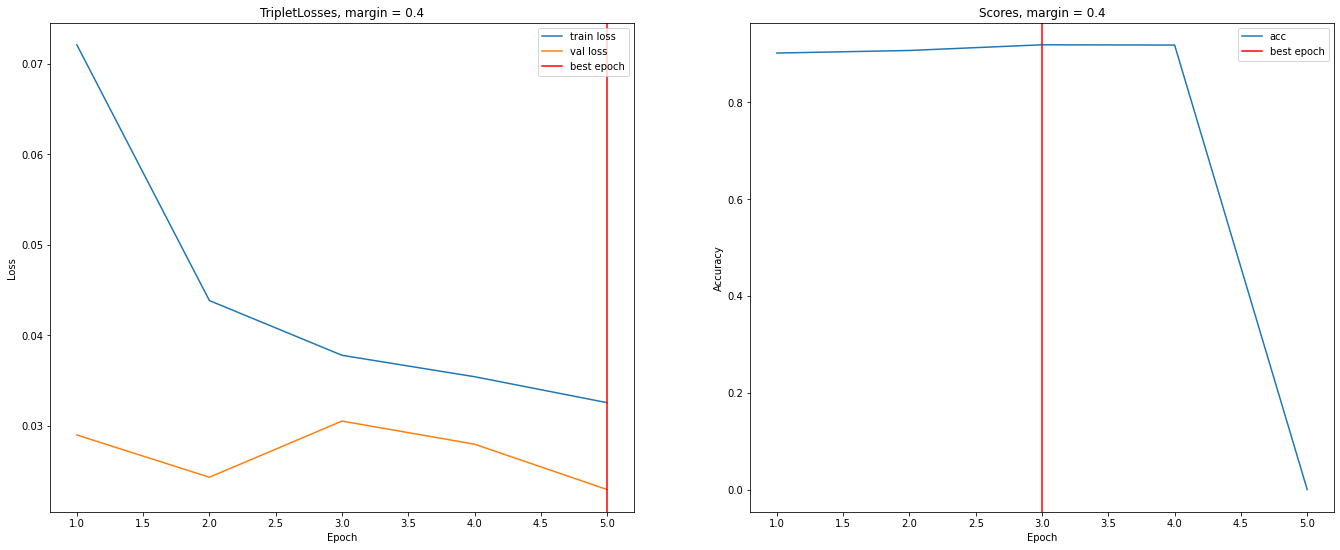

Start testing


  0%|          | 0/25 [00:00<?, ?it/s]

Test TripletLoss = 0.03364653099044604
Test accuracy = 90.56%
Correct answers: 1439 from 1589 
Testing MARGIN = 0.5


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

---------- Epoch 1/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.11830599067474572


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.044301929218145096
Accuracy = 89.72%
Save best model!
Time: 766.8930175304413
---------- Epoch 2/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.06950346461396092


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.04421893987681665
Accuracy = 0.00%
Time: 1530.9746549129486
---------- Epoch 3/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.06381926010275601


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.04212729907292115
Accuracy = 0.00%
Time: 2294.789341211319
---------- Epoch 4/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.05926135831167189


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.04841155957537718
Accuracy = 0.00%
Time: 3061.044780731201
---------- Epoch 5/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.05728263841167595


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.04652470843003581
Accuracy = 91.59%
Save best model!
Time: 3828.071300268173


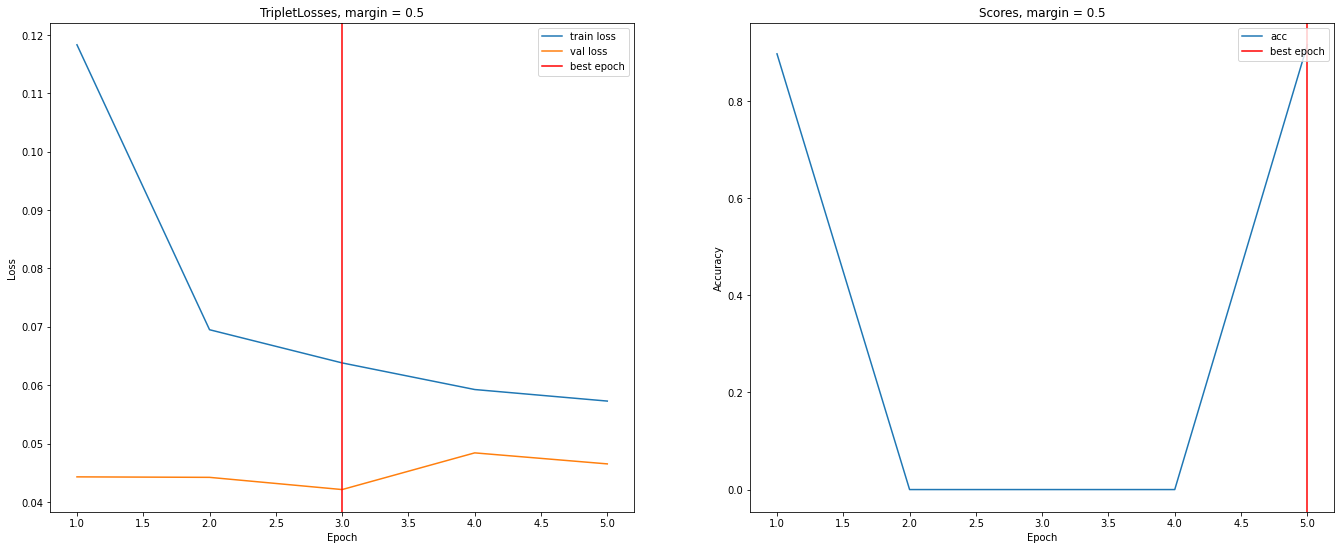

Start testing


  0%|          | 0/25 [00:00<?, ?it/s]

Test TripletLoss = 0.05383746454444151
Test accuracy = 90.56%
Correct answers: 1439 from 1589 


In [ ]:
torch.cuda.empty_cache()
for margin in [0.35, 0.4, 0.5]:
    criterion_TL = nn.TripletMarginWithDistanceLoss(
        distance_function = custom_distance_function, margin=margin
    )
    print('Testing MARGIN = {}'.format(margin))
    # Loading pretrained model
    TL_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
    # Fine-tuning
    for param in TL_model.parameters():
        param.requires_grad = False

    TL_model.last_linear = nn.Linear(
        in_features=1792, out_features=512, bias=False
    )

    TL_model.last_bn = nn.BatchNorm1d(
        num_features=512, eps=0.001, momentum=0.1, affine=True,
        track_running_stats=True
    )

    TL_model.to(DEVICE)
    # Training
    optimizer = optim.Adam(TL_model.parameters(), lr=3e-4, betas=(0.5, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    TL_best_model_weights, train_TLosses, val_TLosses, acc = trainTL(
        TL_model, train_TL_loader, val_TL_loader, optimizer, scheduler,
        criterion_TL,epochs=5, margin=margin
    )
    # Loading best model
    TL_best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
    TL_best_model.load_state_dict(TL_best_model_weights)
    # Testing best model
    print('Start testing')
    test_TLoss, correct, test_accuracy = evaluateTL(
        TL_best_model.to(DEVICE), test_TL_loader, train_TL_loader, criterion_TL
    )

Testing MARGIN = 0.6


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

---------- Epoch 1/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.17818235226449894


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.07553969166530207
Accuracy = 89.51%
Save best model!
Time: 767.4208133220673
---------- Epoch 2/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.11163737337464251


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.07672235411735642
Accuracy = 89.94%
Save best model!
Time: 1536.1387186050415
---------- Epoch 3/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.09859293208140113


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.07105250868458336
Accuracy = 0.05%
Time: 2300.3327765464783
---------- Epoch 4/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.0948063556509518


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.06964657150994474
Accuracy = 88.66%
Time: 3068.3766374588013
---------- Epoch 5/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.09079295673062292


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.07274215751356337
Accuracy = 90.58%
Save best model!
Time: 3834.102935552597


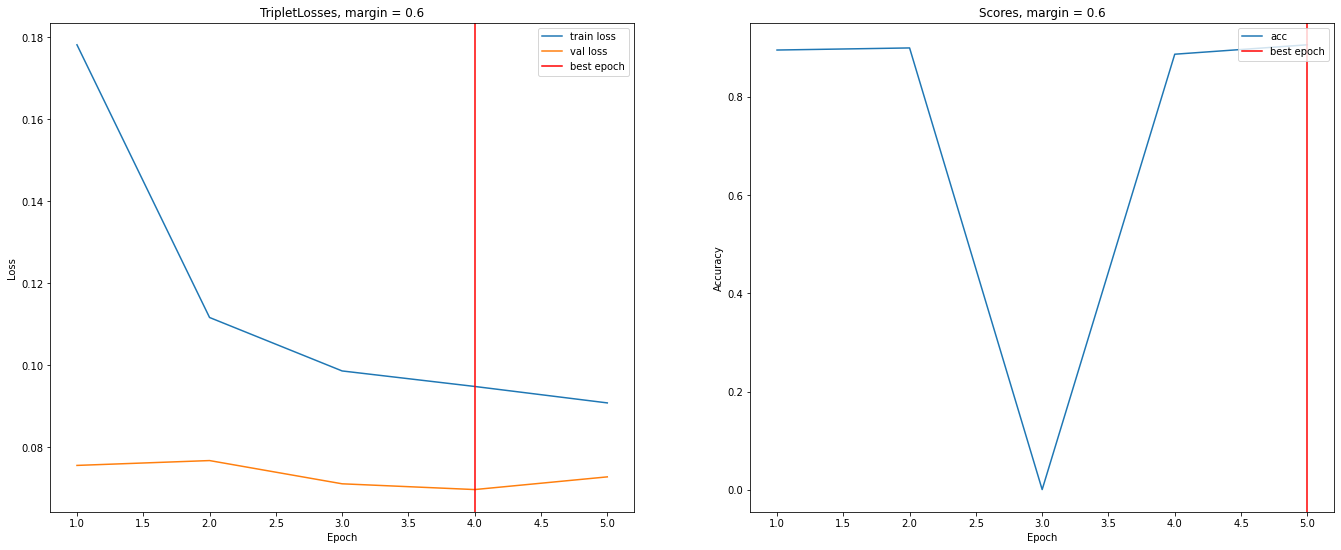

Start testing


  0%|          | 0/25 [00:00<?, ?it/s]

Test TripletLoss = 0.08716758887316912
Test accuracy = 88.92%
Correct answers: 1413 from 1589 


In [ ]:
torch.cuda.empty_cache()
margin = 0.6

criterion_TL = nn.TripletMarginWithDistanceLoss(
    distance_function = custom_distance_function, margin=margin
)
print('Testing MARGIN = {}'.format(margin))
# Loading pretrained model
TL_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
# Fine-tuning
for param in TL_model.parameters():
    param.requires_grad = False

TL_model.last_linear = nn.Linear(
    in_features=1792, out_features=512, bias=False
)

TL_model.last_bn = nn.BatchNorm1d(
    num_features=512, eps=0.001, momentum=0.1, affine=True,
    track_running_stats=True
)

TL_model.to(DEVICE)
# Training
optimizer = optim.Adam(TL_model.parameters(), lr=3e-4, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
TL_best_model_weights, train_TLosses, val_TLosses, acc = trainTL(
    TL_model, train_TL_loader, val_TL_loader, optimizer, scheduler, criterion_TL,
    epochs=5, margin=margin
)
# Loading best model
TL_best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
TL_best_model.load_state_dict(TL_best_model_weights)
# Testing best model
print('Start testing')
test_TLoss, correct, test_accuracy = evaluateTL(
    TL_best_model.to(DEVICE), test_TL_loader, train_TL_loader, criterion_TL
)

**When solving the problem of face recognition, triplet loss shows itself best at margins of 0.2-0.5. A further increase in the margin leads to a significant decrease in the accuracy of the model.**

### ArcFace Loss (Additive Angular Margin Loss) (2 points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

**To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.**

In [ ]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('/content/celebA_train_500/celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join('/content/celebA_train_500/celebA_train_500/celebA_imgs/', filename))

    return np.array(images_paths)


class celebADatasetAF(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('/content/celebA_train_500/celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]


        image = Image.open(img_name)
        face = face_det(image)

        sample = {
            'image': self.transform(face),
            'label': label,
        }

        return sample

In [ ]:
train_AF_data = celebADatasetAF('train', augm)
val_AF_data = celebADatasetAF('val', transform)
test_AF_data = celebADatasetAF('test', transform)

batch_size = 64
train_AF_loader = torch.utils.data.DataLoader(train_AF_data, batch_size=batch_size, shuffle=True)
val_AF_loader = torch.utils.data.DataLoader(val_AF_data, batch_size=batch_size, shuffle=False)
test_AF_loader = torch.utils.data.DataLoader(test_AF_data, batch_size=batch_size, shuffle=False)

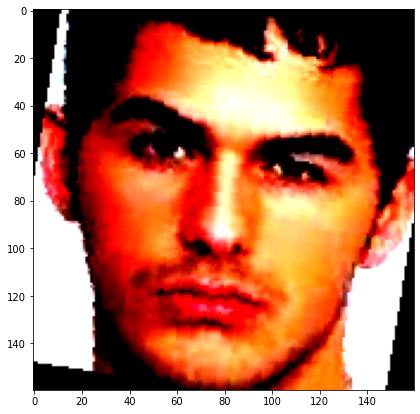

In [ ]:
for i in train_AF_loader:
    plt.subplots(figsize=(15, 30))
    plt.subplot(1, 2, 1)
    plt.imshow(i['image'][4].permute(1, 2, 0))
    break

In [ ]:
class ArcFace_Loss(nn.Module):
    def __init__(self, in_features, out_features, scale=None, margin=None, eps=1e-7):
        super(ArcFace_Loss, self).__init__()

        self.scale = 64.0 if not scale else scale
        self.margin = 0.5 if not margin else margin

        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, logits, labels):
        '''
        logits: tensor(...) => [32, 512]
        labels: tensor([338, 317, ...]) => [32]
        '''
        for W in self.fc.parameters():
            W = F.normalize(W) # normalized weights

        x = F.normalize(logits)  # normalized embeddings (feature) => [32, 512]
        wf = self.fc(x)   # outputs of ArcFace Linear Layer => [32, 500]

        '''
        wf.transpose(0, 1) -- wf.T => [500, 32] {1}
        {1}[labels]  -- get rows by number 'label' from {1} => [32. 32] {2}
        torch.diagonal({2}) -- get diagonal values from {2} => [32] {3}
        torch.acos({3}) -- angle between the feature x_i and the ground truth weight W_y_i => [32]
        '''

        numerator = self.scale * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.margin)

        '''
        [torch.cat((wf[i, :y], wf[i, y+1:])) for i, y in enumerate(labels)] => np.array (32,)
        numerator => [32]
        excl => [32, 499]
        denominator => [32]
        '''

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.scale * excl), dim=1)

        L = numerator - torch.log(denominator)

        return -torch.mean(L)

In [ ]:
AF_BM_WEIGHTS = '/content/gdrive/MyDrive/pr/AF_best_model_weights'

In [ ]:
os.makedirs(AF_BM_WEIGHTS, exist_ok=True)

In [ ]:
class AccuracyAF():
    def __init__(self, model, train_dataloader, batch_size=64):
        with torch.no_grad():
            self.model = model
            sum_embeddings = torch.zeros((500, 512)).to(DEVICE)
            cnt_embeddings = torch.zeros(500).to(DEVICE)
            for batch in train_dataloader:
                embeddings = model(batch['image'].to(DEVICE))
                for i in range(embeddings.shape[0]):
                    label = batch['label'][i]
                    sum_embeddings[label] += embeddings[i]
                    cnt_embeddings[label] += 1
            self.mean_value = torch.zeros((500, 512)).to(DEVICE)
            for j in range(500):
                self.mean_value[j] = sum_embeddings[j] / cnt_embeddings[j]

    def get(self, dataloader):
        sum = 0
        cnt = 0
        with torch.no_grad():
            for batch in dataloader:
                embeddings = self.model(batch['image'].to(DEVICE))
                for i in range(embeddings.shape[0]):
                    pred = F.cosine_similarity(torch.cat((embeddings[i][None][:],) * 500), self.mean_value, dim=1).argmax().item()
                    cnt += 1
                    sum += pred == batch['label'][i]
        return sum / cnt, sum, cnt

In [ ]:
def trainAF(model, train_loader, val_loader, optimizer, scheduler, epochs):
    since = time()

    train_losses = []
    val_losses = []
    full_acc = []
    best_acc = 0.0
    loss_func = ArcFace_Loss(in_features=512, out_features=500, scale=15, margin=0.01).to(DEVICE)
    loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=3e-4, betas=(0.5, 0.999))
    AF_best_model_weights = deepcopy(model.state_dict())

    pbar = trange(epochs, desc='Epoch')

    for epoch in pbar:
        print('---------- Epoch %d/%d ----------' % (epoch+1, epochs))
        # Train
        tr_loss = 0
        model.train()
        for batch in tqdm(train_loader):
            # Forward
            optimizer.zero_grad()
            image = batch['image'].to(DEVICE)
            label = batch['label'].to(DEVICE)
            img_emb = model(image).to(DEVICE)
            output = loss_func(img_emb, label)
            # Backward
            output.backward()
            optimizer.step()
            loss_optimizer.step()

            tr_loss += output.item() * image.size(0)

        optimizer.step()

        train_loss = tr_loss / len(train_loader.sampler)
        train_losses.append(train_loss)
        print('Train loss =', train_loss)
        # Validation
        model.eval()
        v_loss = 0
        num_correct = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                image = batch['image'].to(DEVICE)
                label = batch['label'].to(DEVICE)
                img_emb = model(image).to(DEVICE)
                output = loss_func(img_emb, label)

                v_loss += output.item() * image.size(0)

        val_loss = v_loss / len(val_loader.sampler)
        val_losses.append(val_loss)
        # Accuracy
        accuracy, num_correct, num_elements = AccuracyAF(model, train_loader).get(val_loader)
        full_acc.append(accuracy)
        print('Val loss =', val_loss)
        print('Accuracy = {:.2f}%'.format(accuracy * 100))

        if accuracy >= best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), os.path.join(AF_BM_WEIGHTS, 'AF_Best_model_' + str(epoch + 1) + '.pth'))
            TL_best_model_weights = deepcopy(model.state_dict())
            print('Save best model!')

        scheduler.step()
        print(f'Time: {(time() - since)}')

    plt.subplots(figsize=(23, 9))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='train loss')
    plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    best_ep = np.argmin(val_losses) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='upper right')
    plt.title('ArcFace Losses')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(full_acc) + 1), full_acc, label='acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    best_ep = np.argmax(full_acc) + 1
    plt.axvline(best_ep, color='r', label="best epoch")
    plt.legend(loc='upper right')
    plt.title('Scores')

    plt.show()

    return AF_best_model_weights, train_losses, val_losses, full_acc

In [ ]:
AF_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)

for param in AF_model.parameters():
    param.requires_grad = False

AF_model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
AF_model.last_bn = nn.BatchNorm1d(
    num_features=512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
)

AF_model.to(DEVICE);

In [ ]:
optimizer = optim.Adam(AF_model.parameters(), lr=3e-4, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

---------- Epoch 1/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 2.8443405670619635


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.4042153317516985
Accuracy = 94.20%
Save best model!
Time: 266.0168204307556
---------- Epoch 2/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.36815491910284376


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.6650411308573457
Accuracy = 94.20%
Save best model!
Time: 532.1006400585175
---------- Epoch 3/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.3733408116222767


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.6121914633197653
Accuracy = 93.82%
Time: 798.6654522418976
---------- Epoch 4/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.37377103750178875


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.6478152920167667
Accuracy = 93.50%
Time: 1065.071774482727
---------- Epoch 5/5 ----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss = 0.39296860630146124


  0%|          | 0/30 [00:00<?, ?it/s]

Val loss = 0.6468952156769963
Accuracy = 93.45%
Time: 1344.6654706001282


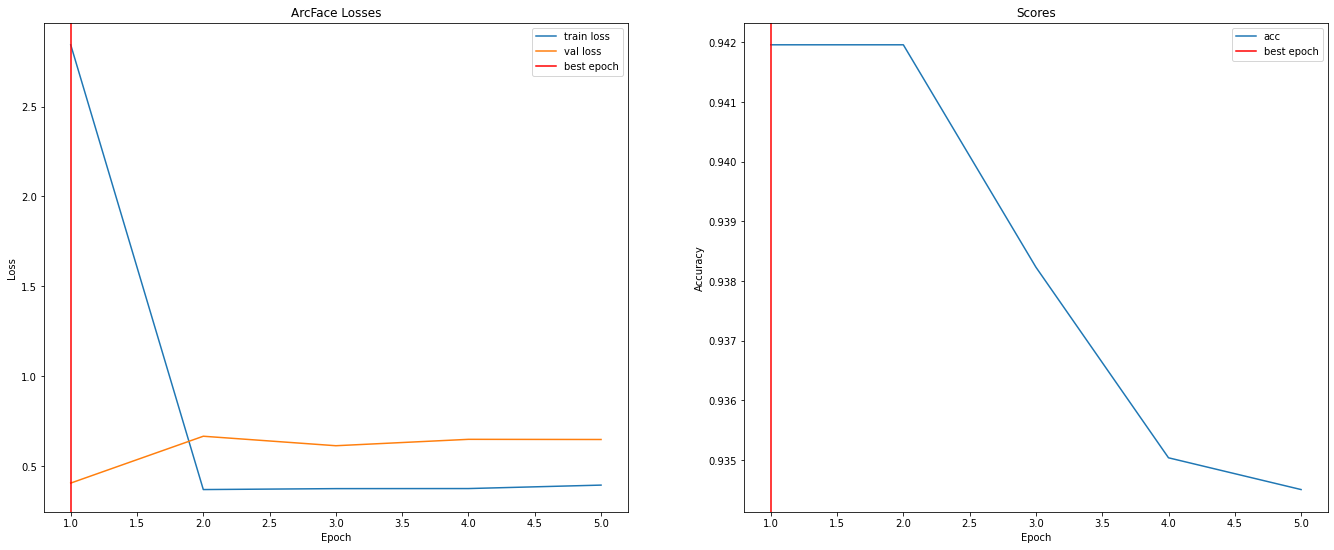

In [ ]:
AF_best_model_weights, train_losses, val_losses, full_acc = trainAF(
    AF_model, train_AF_loader, val_AF_loader, optimizer, scheduler, epochs=5
)

In [ ]:
def evaluateAF(model, dataloader, train_loader):
    loss_func = ArcFace_Loss(in_features=512, out_features=500, scale=15, margin=0.01).to(DEVICE)
    model.eval()
    with torch.no_grad():
        losses = 0
        for batch in tqdm(dataloader):
            image, label = batch['image'].to(DEVICE), batch['label'].to(DEVICE)
            img_emb = model(image).to(DEVICE)

            output = loss_func(img_emb, label)
            losses += output.item() * image.size(0)

    loss = losses / len(dataloader.sampler)
    print('Test ArcFace Loss =', loss)

    accuracy, num_correct, num_elements = AccuracyAF(model, train_loader).get(dataloader)
    print('Test accuracy = {:.2f}%'.format(accuracy * 100))
    print('Correct answers: {} from {} '\
          .format(num_correct, num_elements))

    return loss, num_correct, accuracy

In [ ]:
AF_best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
AF_best_model.load_state_dict(torch.load(os.path.join(AF_BM_WEIGHTS, 'AF_Best_model_2.pth')))
#AF_best_model.load_state_dict(AF_best_model_weights)
test_AFLoss, AF_correct, test_AFaccuracy = evaluateAF(
    AF_best_model.to(DEVICE), test_AF_loader, train_AF_loader
)

  0%|          | 0/25 [00:00<?, ?it/s]

Test ArcFace Loss = 6.410965887985566
Test accuracy = 93.58%
Correct answers: 1487 from 1589 


**As a result, model for the face recognition is best trained on ArcFace loss.**

In [ ]:
CE_training_time = 7695.957328557968
test_acc = '88.67'
TL_m2_training_time = 3936.8378660678864
TL_m2_test_acc = '91.50'
TL_m3_training_time = 3811.9295349121094
TL_m3_test_acc = '91.38'
TL_m35_training_time = 3839.115189552307
TL_m35_test_acc = '91.76'
TL_m4_training_time = 3837.0602898597717
TL_m4_test_acc = '90.56'
TL_m5_training_time = 3828.071300268173
TL_m5_test_acc = '90.56'
TL_m6_training_time = 3834.102935552597
TL_m6_test_acc = '88.92'
AF_training_time = 1344.6654706001282
AF_test_acc = '93.58'

In [ ]:
training_time = [CE_training_time, TL_m2_training_time, TL_m3_training_time,
                 TL_m35_training_time, TL_m4_training_time, TL_m5_training_time,
                 TL_m6_training_time, AF_training_time]
for i in range(len(training_time)):
    training_time[i] = str(int(training_time[i] // 3600 % 24)) + ' h : ' + str(int(training_time[i] % 3600 // 60 // 10)) + str(int(training_time[i] % 3600 // 60 % 10)) + ' min : ' + str(int(training_time[i] % 60 // 10)) + str(int(training_time[i] % 60 % 10)) + ' sec'
print(training_time[5])

1 h : 03 min : 48 sec


In [ ]:
test_acc = [test_acc, TL_m2_test_acc, TL_m3_test_acc, TL_m35_test_acc, TL_m4_test_acc,
            TL_m5_test_acc, TL_m6_test_acc, AF_test_acc]
for i in range(len(test_acc)):
    test_acc[i] = f"{test_acc[i]}%"
test_acc[1]

'91.50%'

In [ ]:
data = np.array([training_time[0], test_acc[0], training_time[1], test_acc[1],
                 training_time[2], test_acc[2], training_time[3], test_acc[3],
                 training_time[4], test_acc[4], training_time[5], test_acc[5],
                 training_time[6], test_acc[6], training_time[7], test_acc[7]]).reshape(8, 2)

rows = ["Exp #1. Inception Resnet v.1 with Cross Entropy loss", "Exp #2. Inception Resnet v.1 with Tripletloss (margin = 0.2)",
        "Exp #3. Inception Resnet v.1 with Tripletloss (margin = 0.3)", "Exp #4. Inception Resnet v.1 with Tripletloss (margin = 0.35)",
        "Exp #5. Inception Resnet v.1 with Tripletloss (margin = 0.4)", "Exp #6. Inception Resnet v.1 with Tripletloss (margin = 0.5)",
        "Exp #7. Inception Resnet v.1 with Tripletloss (margin = 0.6)", "Exp #8. Inception Resnet v.1 with ArcFace loss"]
cols = ["training time", "test accuracy"]
df = pd.DataFrame(data=data, index=rows, columns=cols)
df

training time  \
Exp #1. Inception Resnet v.1 with Cross Entropy...  2 h : 08 min : 15 sec   
Exp #2. Inception Resnet v.1 with Tripletloss (...  1 h : 05 min : 36 sec   
Exp #3. Inception Resnet v.1 with Tripletloss (...  1 h : 03 min : 31 sec   
Exp #4. Inception Resnet v.1 with Tripletloss (...  1 h : 03 min : 59 sec   
Exp #5. Inception Resnet v.1 with Tripletloss (...  1 h : 03 min : 57 sec   
Exp #6. Inception Resnet v.1 with Tripletloss (...  1 h : 03 min : 48 sec   
Exp #7. Inception Resnet v.1 with Tripletloss (...  1 h : 03 min : 54 sec   
Exp #8. Inception Resnet v.1 with ArcFace loss      0 h : 22 min : 24 sec   

                                                   test accuracy  
Exp #1. Inception Resnet v.1 with Cross Entropy...        88.67%  
Exp #2. Inception Resnet v.1 with Tripletloss (...        91.50%  
Exp #3. Inception Resnet v.1 with Tripletloss (...        91.38%  
Exp #4. Inception Resnet v.1 with Tripletloss (...        91.76%  
Exp #5. Inception Resnet v.1 with Tripletloss (...        90.56%  
Exp #6. Inception Resnet v.1 with Tripletloss (...        90.56%  
Exp #7. Inception Resnet v.1 with Tripletloss (...        88.92%  
Exp #8. Inception Resnet v.1 with ArcFace loss            93.58%